In [6]:
from lib.dataloader import get_dataloader
from model.models_evaluateLosses import STSSL
import yaml
import argparse
from lib.utils import (
    init_seed,
    get_model_params,
    load_graph, 
)

class Args:
    def __init__(self):
        self.data_dir = 'data'
        self.dataset = 'NYCBike2'
        self.batch_size = 32
        self.test_batch_size = 32
        self.device = 'cuda'
        self.seed = 2
        self.mode = 'test'
        self.best_path = None
        self.debug = False
        self.input_length = 35
        self.graph_file = 'data/NYCBike2/adj_mx.npz'
        self.num_nodes = 200
        self.d_input = 2
        self.d_output = 2
        self.d_model = 64
        self.dropout = 0.1
        self.percent = 0.1
        self.shm_temp = 0.5
        self.nmb_prototype = 4
        self.yita = 0.5
        self.epochs = 1000
        self.lr_init = 0.001
        self.early_stop = True
        self.early_stop_patience = 35
        self.grad_norm = True
        self.max_grad_norm = 5
        self.use_dwa = True
        self.temp = 2
        self.graph_init = '8_neighbours'
        # self.graph_init = 'shared_lpe_raw'
        self.self_attention_flag = True
        self.cross_attention_flag = False
        self.feedforward_flag = False
        self.layer_norm_flag = False
        self.additional_sa_flag = False
        self.learnable_flag = False
        self.cheb_order = 3
args = Args()
dataloader = get_dataloader(
        data_dir=args.data_dir, 
        dataset=args.dataset, 
        batch_size=args.batch_size, 
        test_batch_size=args.test_batch_size,
        scalar_type='Standard'
    )


# model = STSSL(args).to(args.device)
# model_parameters = get_model_params([model])

data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2)


In [7]:
import torch
import numpy as np
from lib.metrics import test_metrics_evalLosses

@staticmethod
def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            repr1, repr2 = model(data, graph)                
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0))
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0))
    # y_true.shape [546, 1, 200, 2] 
    ## indec dim 2 with the mask from attention_matrix
    adj_mx_np = np.load(r'D:\omer\ST-SSL\data\NYCBike2\adj_lpe_shared_raw.npz')["adj_mx"]
    adj_mx = torch.from_numpy(adj_mx_np).to(args.device)
    att_given = torch.sum(adj_mx, dim=0).reshape(-1, 1)
    mask_att = att_given > 0.75   ## mask of where the attention is high

    # mask_expanded = mask_att.unsqueeze(0).unsqueeze(0)
    mask_expanded = mask_att.expand_as(y_true)
    num_good = torch.sum(mask_expanded).item()
    num_bad = torch.sum(~mask_expanded).item()

    # y_true_good = y_true * mask_expanded
    # y_pred_good = y_pred * mask_expanded
    # y_true_bad = y_true * ~mask_expanded
    # y_pred_bad = y_pred * ~mask_expanded
    y_true_good_in = torch.masked_select(y_true[..., 0], mask_expanded[..., 0].bool())
    y_pred_good_in = torch.masked_select(y_pred[..., 0], mask_expanded[..., 0].bool())
    y_true_bad_in = torch.masked_select(y_true[..., 0], ~mask_expanded[..., 0].bool())
    y_pred_bad_in = torch.masked_select(y_pred[..., 0], ~mask_expanded[..., 0].bool()) 
    y_true_good_out = torch.masked_select(y_true[..., 1], mask_expanded[..., 1].bool())
    y_pred_good_out = torch.masked_select(y_pred[..., 1], mask_expanded[..., 1].bool())
    y_true_bad_out = torch.masked_select(y_true[..., 1], ~mask_expanded[..., 1].bool())
    y_pred_bad_out = torch.masked_select(y_pred[..., 1], ~mask_expanded[..., 1].bool())
    # print(f"y_true_good shape: {y_true_good.shape}, y_true.shape: {y_true.shape}")
    test_results = []
    # inflow
    mae_bad, mae_med, mae_good, mape, count_bad, count_med, count_good, mae_original = test_metrics_evalLosses(y_pred[..., 0], y_true[..., 0])
    print(f"INFLOW:: MAE_BAD: {mae_bad}, MAE_MED: {mae_med}, MAE_GOOD: {mae_good}, MAPE: {mape}, COUNT_BAD: {count_bad}, COUNT_MED: {count_med}, COUNT_GOOD: {count_good}, ORIGINAL_MAE: {mae_original}")
    test_results.append([mae_good, mape])
    # outflow 
    mae_bad, mae_med, mae_good, mape, count_bad, count_med, count_good, mae_original = test_metrics_evalLosses(y_pred[..., 1], y_true[..., 1])
    print(f"OUTFLOW:: MAE_BAD: {mae_bad}, MAE_MED: {mae_med}, MAE_GOOD: {mae_good}, MAPE: {mape}, COUNT_BAD: {count_bad}, COUNT_MED: {count_med}, COUNT_GOOD: {count_good}, ORIGINAL_MAE: {mae_original}")
    test_results.append([mae_good, mape]) 


    print(f"================BAD NODES, {num_bad}=======================")
    mae_bad, mae_med, mae_good, mape, count_bad, count_med, count_good, mae_original = test_metrics_evalLosses(y_pred_bad_in, y_true_bad_in)
    print(f"INFLOW:: MAE_BAD: {mae_bad}, MAE_MED: {mae_med}, MAE_GOOD: {mae_good}, MAPE: {mape}, COUNT_BAD: {count_bad}, COUNT_MED: {count_med}, COUNT_GOOD: {count_good}, ORIGINAL_MAE: {mae_original}")
    test_results.append([mae_good, mape])
    # outflow 
    mae_bad, mae_med, mae_good, mape, count_bad, count_med, count_good, mae_original = test_metrics_evalLosses(y_pred_bad_out, y_true_bad_out)
    print(f"OUTFLOW:: MAE_BAD: {mae_bad}, MAE_MED: {mae_med}, MAE_GOOD: {mae_good}, MAPE: {mape}, COUNT_BAD: {count_bad}, COUNT_MED: {count_med}, COUNT_GOOD: {count_good}, ORIGINAL_MAE: {mae_original}")
    test_results.append([mae_good, mape]) 


    print(f"================GOOD NODES, {num_good}=======================")
    mae_bad, mae_med, mae_good, mape, count_bad, count_med, count_good, mae_original = test_metrics_evalLosses(y_pred_good_in, y_true_good_in)
    print(f"INFLOW:: MAE_BAD: {mae_bad}, MAE_MED: {mae_med}, MAE_GOOD: {mae_good}, MAPE: {mape}, COUNT_BAD: {count_bad}, COUNT_MED: {count_med}, COUNT_GOOD: {count_good}, ORIGINAL_MAE: {mae_original}")
    test_results.append([mae_good, mape])
    # outflow 
    mae_bad, mae_med, mae_good, mape, count_bad, count_med, count_good, mae_original = test_metrics_evalLosses(y_pred_good_out, y_true_good_out)
    print(f"OUTFLOW:: MAE_BAD: {mae_bad}, MAE_MED: {mae_med}, MAE_GOOD: {mae_good}, MAPE: {mape}, COUNT_BAD: {count_bad}, COUNT_MED: {count_med}, COUNT_GOOD: {count_good}, ORIGINAL_MAE: {mae_original}")
    test_results.append([mae_good, mape]) 
    return np.stack(test_results, axis=0)

In [8]:
# model_path = r"D:\omer\ST-SSL\experiments\NYCTaxi\pred__seed=1\20240607-132543\8_neighbours adj_mx, 2 sa on 128\best_model.pth"
# model_path = r"D:\omer\ST-SSL\experiments\NYCTaxi\pred__seed=1\20240607-131720\shared_lpe_raw adj_mx, 2 sa on 128\best_model.pth"
# model_path = r"D:\omer\ST-SSL\experiments\BJTaxi\pred__seed=2\20240607-202939\8_neighbours adj_mx, 2 sa on 128\best_model.pth"
# model_path = r"D:\omer\ST-SSL\experiments\BJTaxi\pred__seed=2\20240607-183024\shared_lpe_raw adj_mx, 2 sa on 128\best_model.pth"
# model_path = r"D:\omer\ST-SSL\experiments\NYCBike1\pred__seed=2\20240606-195334\8_neighbours adj_mx, 2 sa on 128\best_model.pth"
# model_path = r"D:\omer\ST-SSL\experiments\NYCBike1\pred__seed=2\20240607-111833\shared_lpe_raw adj_mx, 2 sa on 128\best_model.pth"
model_path = r"D:\omer\ST-SSL\experiments\NYCBike2\pred__seed=1\20240606-222807\8_neighbours adj_mx, 2 sa on 128\best_model.pth"
# model_path = r"D:\omer\ST-SSL\experiments\NYCBike2\pred__seed=1\20240607-115101\shared_lpe_raw adj_mx, 2 sa on 128\best_model.pth"
model = STSSL(args).to(args.device)
## implement proper load_state_dict so that it gives error when extra keys are present (get from i-jepa)
model_parameters = get_model_params([model])

msg = model.load_state_dict(torch.load(model_path)["model"])
print(f"msg: {msg}")
model.to(args.device)
model.eval()

test_results = test(model, dataloader['test'], dataloader['scaler'], load_graph(args.graph_file), None, args)

msg: <All keys matched successfully>
INFLOW:: MAE_BAD: 8.069442749023438, MAE_MED: 4.901631832122803, MAE_GOOD: nan, MAPE: nan, COUNT_BAD: 91048, COUNT_MED: 18152, COUNT_GOOD: 0, ORIGINAL_MAE: 4.901631832122803
OUTFLOW:: MAE_BAD: 7.635995864868164, MAE_MED: 4.570273399353027, MAE_GOOD: nan, MAPE: nan, COUNT_BAD: 91175, COUNT_MED: 18025, COUNT_GOOD: 0, ORIGINAL_MAE: 4.570273399353027
================BAD NODES, 168168=======================
INFLOW:: MAE_BAD: 8.379229545593262, MAE_MED: 2.114600658416748, MAE_GOOD: nan, MAPE: nan, COUNT_BAD: 82300, COUNT_MED: 1784, COUNT_GOOD: 0, ORIGINAL_MAE: 2.114600658416748
OUTFLOW:: MAE_BAD: 7.920226573944092, MAE_MED: 2.0771913528442383, MAE_GOOD: nan, MAPE: nan, COUNT_BAD: 82338, COUNT_MED: 1746, COUNT_GOOD: 0, ORIGINAL_MAE: 2.0771913528442383
================GOOD NODES, 50232=======================
INFLOW:: MAE_BAD: 5.155012130737305, MAE_MED: 5.205399990081787, MAE_GOOD: nan, MAPE: nan, COUNT_BAD: 8748, COUNT_MED: 16368, COUNT_GOOD: 0, ORIGINAL_M

In [5]:
((1784*2.2011232376098633)+(16368*5.278149604797363))/(1784+16368)

4.975735819040284

In [14]:
((145236*3.6453)+(73164*13.95230))/(145236+73164)

7.098145

In [ ]:
len(dataloader['test'])

18

In [13]:
((237010*7.415)+(751504*17.101))/(237010+751504)

14.778646588718015

In [10]:
((6330*1.987)+(36289*10.787))/(6330+36289)

9.479977310589176

In [9]:
((4868*2.0200)+(28844*13.108))/(4868+28844)

11.506897009966776

in_train.shape: (200,)


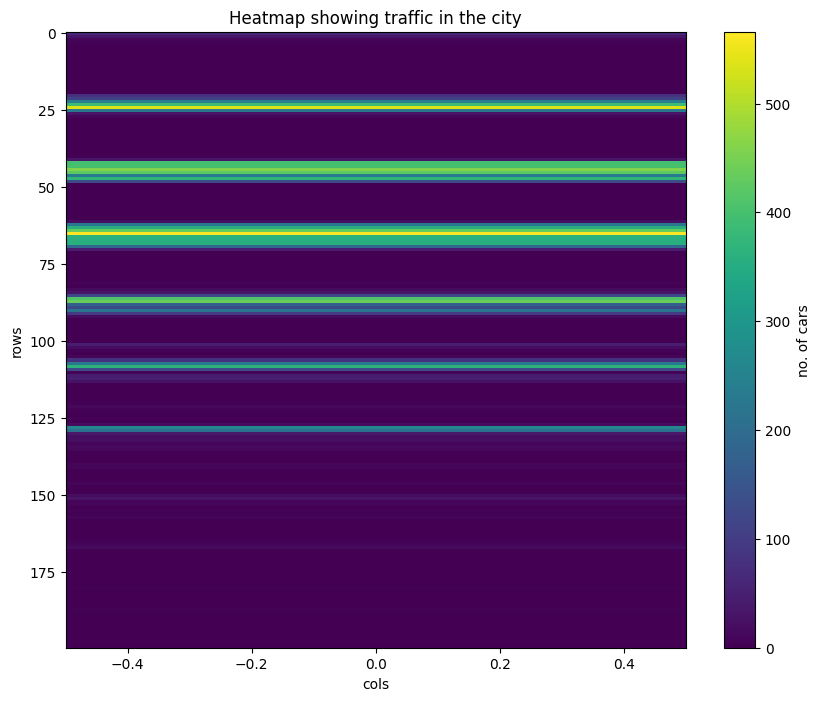

In [41]:
import numpy as np
x_train = np.load(r'D:\omer\ST-SSL\data\NYCTaxi\train.npz')["x"]
# y_train = np.load(r'E:\estudy\ST-SSL\code\ST-SSL\data\NYCTaxi\train.npz')["y"]
# print(f"len(data_train): {len(x_train)}")
# print(f"y_train.shape: {y_train.shape}")
in_train = x_train[0, 0, :, 0]
# out_train = x_train[:, :, :, 1]
print(f"in_train.shape: {in_train.shape}")
# in_train_avg = np.sum(in_train, axis=0)
# out_train_avg = np.sum(out_train, axis=0).squeeze(0).reshape(20, 10)
# print(f"in_train_avg.shape: {in_train_avg.shape}")
# in_train_avg[in_train_avg<1000] = -np.inf
# inout_train_avg = (in_train_avg + out_train_avg)/2
# in_train[in_train < 5] = 900
# in_train[(in_train > 5) & (in_train < 10)] = -np.inf

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(in_train.reshape(-1, 1), cmap='viridis', aspect='auto')
plt.colorbar(label='no. of cars')
plt.title('Heatmap showing traffic in the city')
plt.xlabel('cols')
plt.ylabel('rows')
plt.show()

adj_mx.shape: (1024, 1024)


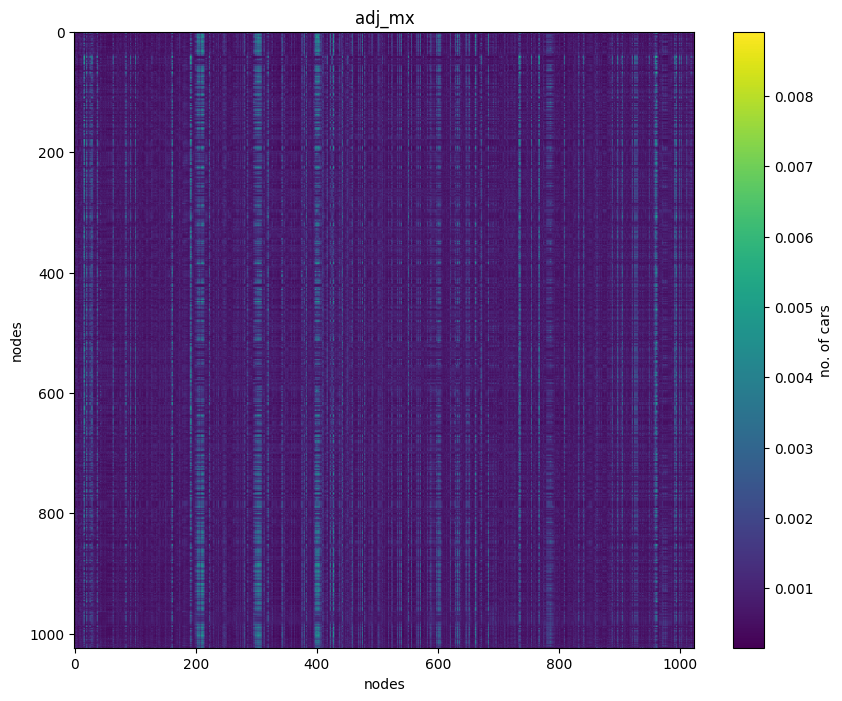

In [42]:
adj_mx = np.load(r'D:\omer\ST-SSL\data\BJTaxi\adj_mx.npz')["adj_mx"]
adj_mx = np.load(r'D:\omer\ST-SSL\data\BJTaxi\adj_lpe_shared_raw.npz')["adj_mx"]

print(f"adj_mx.shape: {adj_mx.shape}")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(adj_mx, cmap='viridis', aspect='auto')
plt.colorbar(label='no. of cars')
plt.title('adj_mx')
plt.xlabel('nodes')
plt.ylabel('nodes')
plt.show()



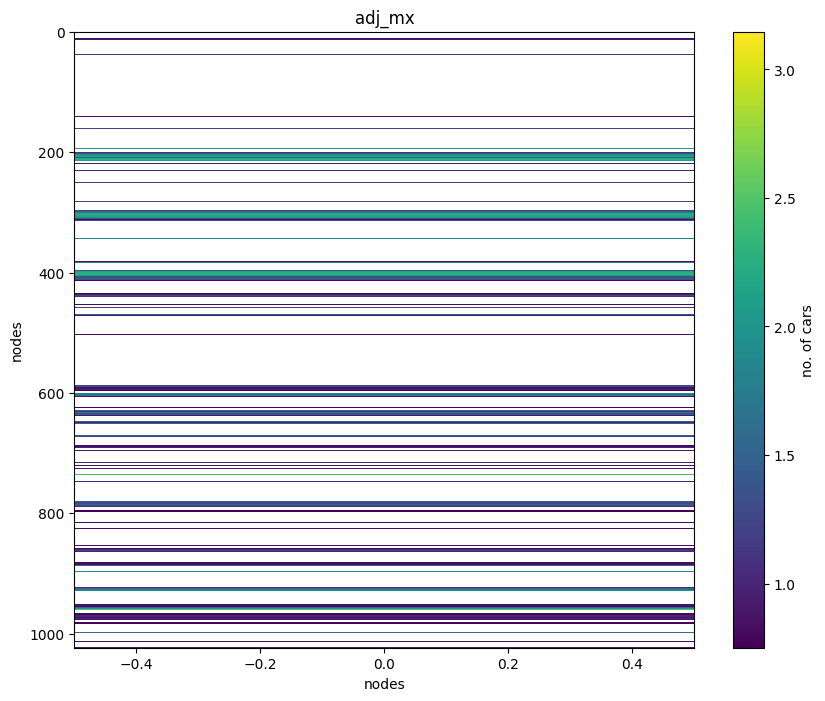

In [28]:
adj_mx = np.load(r'D:\omer\ST-SSL\data\BJTaxi\adj_lpe_shared_raw.npz')["adj_mx"]
att_given = adj_mx.sum(axis=0).reshape(-1, 1)
mask_att=att_given<0.75
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
att_given[att_given<.75] = -np.inf
plt.imshow(att_given, cmap='viridis', aspect='auto')
plt.colorbar(label='no. of cars')
plt.title('adj_mx')
plt.xlabel('nodes')
plt.ylabel('nodes')
plt.show()

In [47]:
mask_att=att_given<0.75
print(mask_att.shape)

(200, 1)


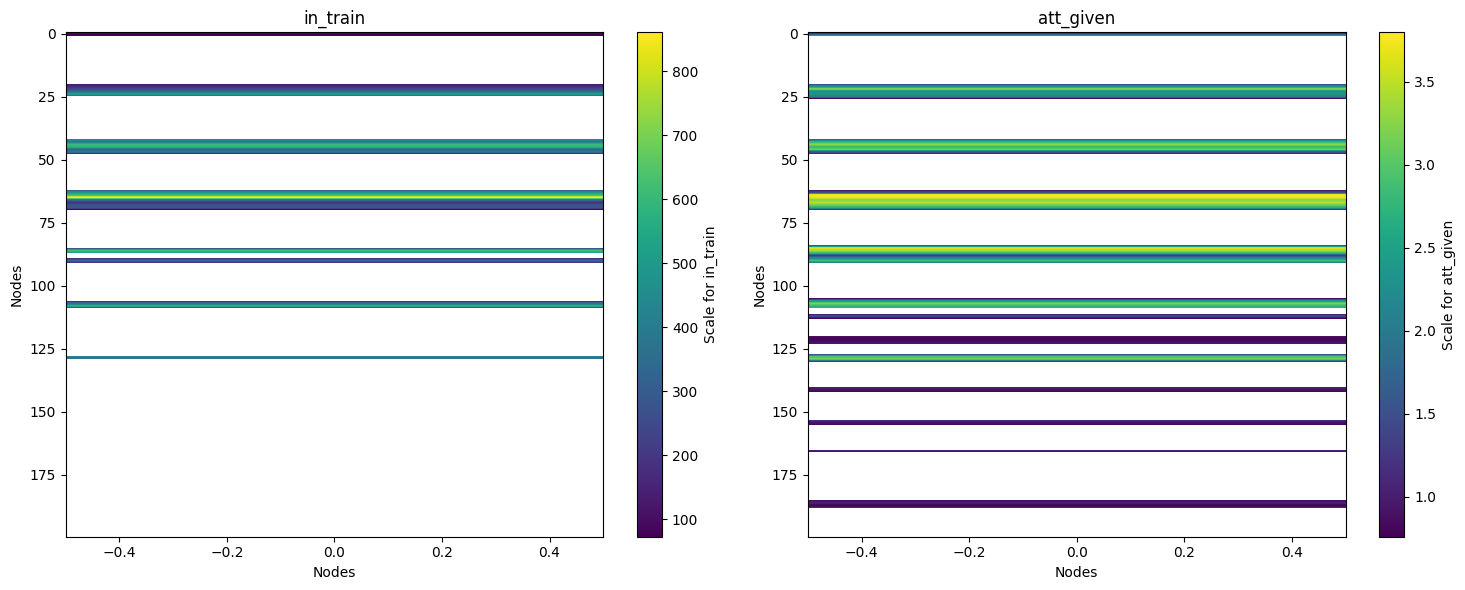

In [48]:

import numpy as np
import matplotlib.pyplot as plt
x_train = np.load(r'D:\omer\ST-SSL\data\NYCTaxi\train.npz')["x"]
in_train = x_train[0, 1, :, 0]
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
_att_given = att_given.copy()
_att_given[att_given < 0.75] = -np.inf
# First matrix
in_train = in_train.reshape(-1, 1)
_in_train = in_train.copy()
# _in_train[(_in_train > 5) & (att_given < 0.8)] = -np.inf
_in_train[(_in_train <= 70)] = -np.inf
im1 = axes[0].imshow(_in_train.reshape(-1, 1), cmap='viridis', aspect='auto')
fig.colorbar(im1, ax=axes[0], label='Scale for in_train')
axes[0].set_title('in_train')
axes[0].set_xlabel('Nodes')
axes[0].set_ylabel('Nodes')

# Second matrix
im2 = axes[1].imshow(_att_given.reshape(-1, 1), cmap='viridis', aspect='auto')
fig.colorbar(im2, ax=axes[1], label='Scale for att_given')
axes[1].set_title('att_given')
axes[1].set_xlabel('Nodes')
axes[1].set_ylabel('Nodes')

# Adjust layout
plt.tight_layout()
plt.show()
